In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ushealthinsurancedataset/insurance.csv


# US Health Insurance

Insurance Premium Charges in US with important details for risk underwriting.

Dataset is [here](https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset).

### Contents
1. [Import Data](#import)
2. [Data Exploration (EDA - Exploratory Data Analysis)](#eda)
3. [Feature Encoding](#encoding)
4. [Modelling](#modelling)
5. [What is MSE, R² and Adjusted R²?](#conclusion)
6. [Sources](#sources)

## Import Data  <a id="import"></a>

In [2]:
data = pd.read_csv('/kaggle/input/ushealthinsurancedataset/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Here is a detailed explanation of each feature presented in the summary table of a health insurance data set, highlighting important aspects of each:

### 1. Age
- **Mean (Average) ~ 39.2**: This indicates that the average age of individuals in the data set is around 39, which suggests that a significant portion of the demographic is middle-aged.
- **Min/Max**: The age range spans from 18 to 64 years.

### 2. BMI (Body Mass Index)
- **Mean (Average) ~ 30.66**: The average [BMI](https://www.cdc.gov/healthyweight/assessing/bmi/index.html#:~:text=Body%20Mass%20Index%20(BMI)%20is,or%20health%20of%20an%20individual.) slightly exceeds 30, categorizing the average individual as mildly obese. This high average BMI suggests that insurance companies need to account for potential high risks associated with obesity-related health issues.
- **Min/Max**: BMI values range from 15.96 to 53.13.

### 3. Children
- **Mean (Average) ~ 1.09**: On average, insured individuals have about one child.
- **Max**: The maximum number of children is 5, indicating that some families may need more extensive health insurance coverage, and family size could impact insurance costs.

### 4. Charges (Insurance Costs)
- **Mean (Average) ~ 13270.42**: The average annual insurance charge is approximately 13.270 dollars.
- **Min/Max**: Insurance charges range from 1,121.87 to 63,770.43 dollars. This wide range reflects a broad spectrum of health needs and risk profiles among clients, emphasizing the variability in insurance requirements and costs.

## Data Exploration (EDA - Exploratory Data Analysis) <a id="eda"></a>

In [5]:
#unique values for columns
for column in data.columns:
    print(f"{column}: {data[column].nunique()} unique values")

age: 47 unique values
sex: 2 unique values
bmi: 548 unique values
children: 6 unique values
smoker: 2 unique values
region: 4 unique values
charges: 1337 unique values


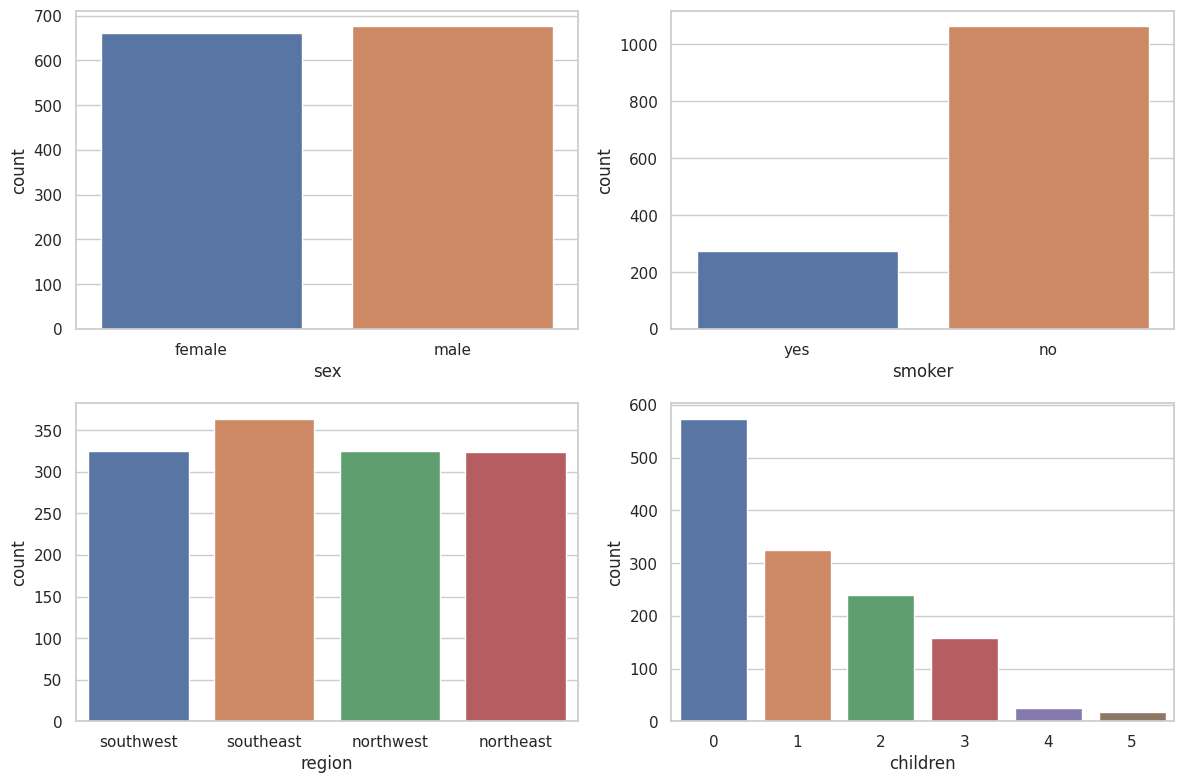

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.countplot(x='sex', data=data, ax=axes[0, 0])
sns.countplot(x='smoker', data=data, ax=axes[0, 1])
sns.countplot(x='region', data=data, ax=axes[1, 0])
sns.countplot(x='children', data=data, ax=axes[1, 1])
plt.tight_layout()


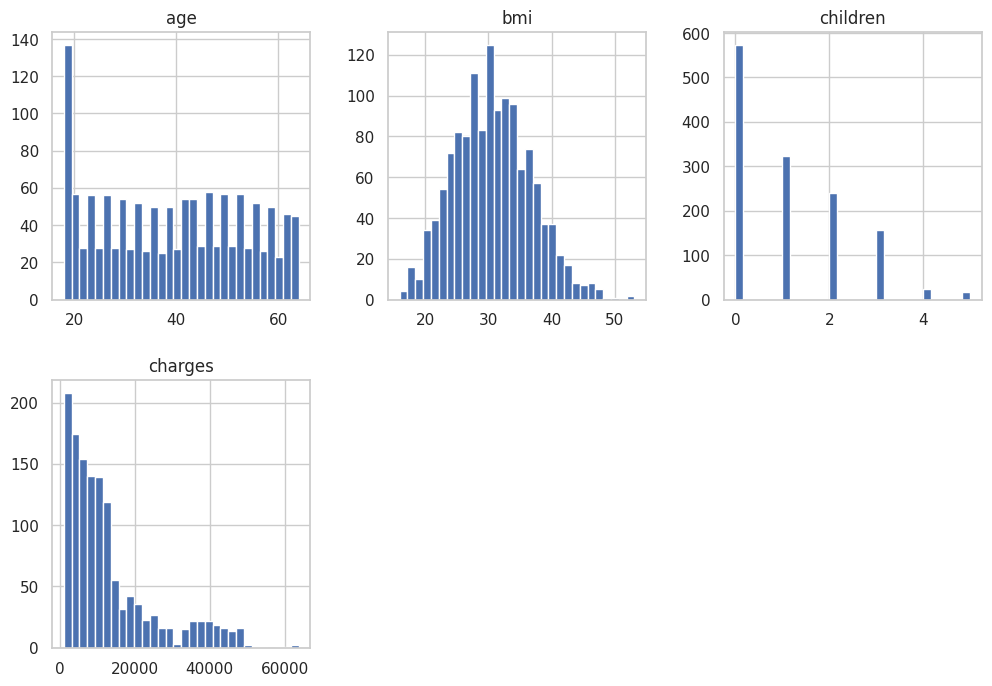

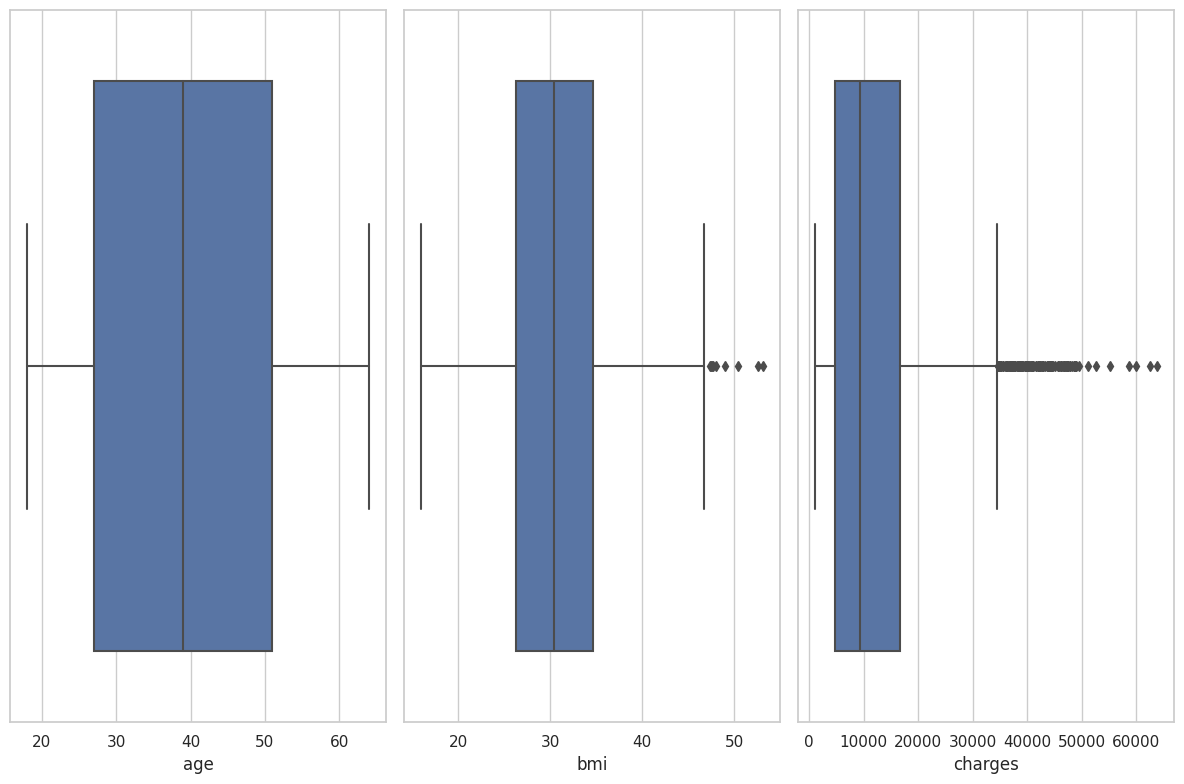

In [7]:
data.hist(bins=30, figsize=(12, 8), layout=(2, 3))
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
sns.boxplot(x=data['age'], ax=axes[0])
sns.boxplot(x=data['bmi'], ax=axes[1])
sns.boxplot(x=data['charges'], ax=axes[2])
plt.tight_layout()


### 1. Age
- The high representation of young adults, particularly those who are recent college graduates or new entrants into the workforce, might indicate a high uptake of health insurance within this demographic. This could be useful for targeted marketing or policy development efforts focused on this age group.

### 2. BMI (Body Mass Index)
- Obesity can directly impact health insurance costs as it often leads to various health issues. This distribution is crucial for insurance companies during risk assessments and pricing policies.

### 3. Children
- The predominance of individuals without children in the insurance market may suggest a higher interest in insurance plans among young adults or childless couples. This information could be vital for marketing family plans or offerings tailored to families with children.

### 4. Charges (Insurance Costs)
- The fact that most insured individuals incur low healthcare costs suggests a generally low risk. However, high-cost cases could disrupt the balance of the insurance pool and may represent rare and expensive health conditions or emergency medical interventions.

## Feature Encoding <a id="encoding"></a>

In [8]:
#sex
data["sex"] = np.where(data["sex"] == "female", '1', '2')
#smoker
data["smoker"] = np.where(data["smoker"] == "yes", '1', '0')
#region
conditions = [
    (data["region"] == "southwest"),
    (data["region"] == "southeast"),
    (data["region"] == "northwest"),
    (data["region"] == "northeast")
]

choices = ['1', '2', '3', '4']

data["region"] = np.select(conditions, choices)

#final data
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,1,16884.92400
1,18,2,33.770,1,0,2,1725.55230
2,28,2,33.000,3,0,2,4449.46200
3,33,2,22.705,0,0,3,21984.47061
4,32,2,28.880,0,0,3,3866.85520


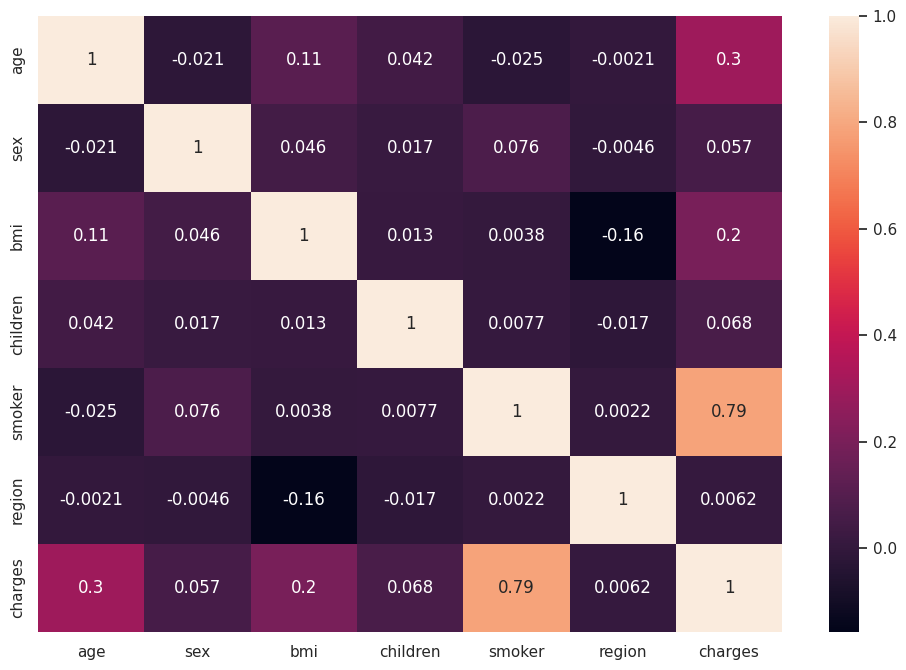

In [9]:
# correlations between features
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True)
plt.show()

### Smoking and Charges

The correlation coefficient is observed to be 0.79, indicating a substantially high positive correlation. This suggests that individuals who smoke incur significantly higher insurance costs compared to non-smokers. The detrimental effects of smoking on health and the consequent increase in healthcare expenses can explain this relationship.

### Age and Charges

The correlation coefficient stands at 0.3, representing a moderate positive correlation. Accordingly, as age increases, there tends to be an upward trend in insurance costs.

## Modelling <a id="modelling"></a>

In [10]:
#libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
#train-test split
X = data.drop('charges', axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
#models
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression": make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "SVR": make_pipeline(StandardScaler(), SVR())
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    p = X_test.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    results[name] = (mse, r2, adjusted_r2)
    print(f'{name} -> MSE: {mse:.2f}, R2: {r2:.4f}, Adjusted R2: {adjusted_r2:.5f}')

#best model
best_model = min(results, key=lambda x: results[x][0])  # Best model according to MSE
print(f'\n\nBest Model: {best_model} with MSE: {results[best_model][0]:.2f}')

Linear Regression -> MSE: 33635210.43, R2: 0.7833, Adjusted R2: 0.77837
Polynomial Regression -> MSE: 20601253.80, R2: 0.8673, Adjusted R2: 0.86425
Ridge Regression -> MSE: 33675792.15, R2: 0.7831, Adjusted R2: 0.77810
Lasso Regression -> MSE: 33635622.35, R2: 0.7833, Adjusted R2: 0.77836
Decision Tree -> MSE: 44113091.22, R2: 0.7159, Adjusted R2: 0.70932
Random Forest -> MSE: 21351529.93, R2: 0.8625, Adjusted R2: 0.85931
SVR -> MSE: 165839509.92, R2: -0.0682, Adjusted R2: -0.09277


Best Model: Polynomial Regression with MSE: 20601253.80


## What is MSE, R² and Adjusted R²? <a id="conclusion"></a>

Here are simplified explanations of MSE (Mean Squared Error), R-squared (R²), and Adjusted R-squared (Adjusted R²), key statistical metrics used to evaluate regression models. These metrics help us understand how well a regression model performs and how accurately it explains the data.

### 1. MSE (Mean Squared Error)
- MSE measures how far a model's predictions are from the actual values. It is calculated as the average of the squares of the differences between the actual values and the predicted values. A lower MSE indicates that the model's predictions are close to the actual values, suggesting better performance. The smaller the MSE, the better the model is considered to be.

### 2. R² (R-squared)
- R-squared quantifies the proportion of the variance in the dependent variable that is predictable from the independent variables. It essentially shows what fraction of the total variance in the data is explained by the model. R-squared values range from 0 to 1. A value close to 1 indicates that the model explains a large portion of the variance in the data effectively. A value close to 0 indicates that the model fails to explain the variability in the data adequately.

### 3. Adjusted R² (Adjusted R-squared)
- R-squared tends to increase with the addition of independent variables, regardless of whether those variables are truly helpful for the model. Adjusted R-squared adjusts the R-squared value to account for the number of independent variables in the model. Adjusted R² provides a more realistic measure of model performance by taking into account the number of independent variables. It is generally lower than R² and provides a more accurate reflection of the model's effectiveness in the real world. A high Adjusted R² indicates that the model is both accurate and efficient.

These metrics not only assess how good a model is but also facilitate comparisons between different models. Evaluating these metrics during model selection helps in choosing the most suitable model.

## Sources <a id="sources"></a>

- [Source 1](https://www.bmc.com/blogs/mean-squared-error-r2-and-variance-in-regression-analysis/)
- [Source 2](https://ieeexplore.ieee.org/document/9850653)